# Modelling Stepper Motor Detent Torque

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Single Harmonic Detent Model

For a hybrid stepper, the detent torque can be modeled as a periodic function of rotor angle $\theta$.:

$$
\tau_{det} (\theta) = T_{dm} sin(2p\theta+\phi)
$$

Where:
- $\theta$ is the mechanical rotor angle in radians
- $p$ is the number of pole-pairs in the motor
- $T_{dm}$ is the detent torque amplitude
- $\phi$ is a phase offset

## Multi Harmonic Detent Model
A better model includes several harmonics of that basic periodicity from the number of pole pairs. We then get:

$$
\tau_{det} (\theta) = \sum_{k=1}^{N_h} T_{k} sin(k 2 p \theta + \phi_k)
$$

Where now:
- $T_k$ is the amplitude of the kth harmonic
- $\phi_k$ is the phase offset for that particular harmonic
- $N_h$ is the number of harmonics included

This is a fourier style model and is similar to that used by Salamanca in his experiments. Lets define some functions to
handle this.

In [2]:
# ==============================
# Model functions
# ==============================

def tau_det_single(theta, T_dm, p, phi):
    """
    Single-harmonic detent torque model.

    Parameters
    ----------
    theta : array_like
        Mechanical rotor angle [rad].
    T_dm : float
        Fundamental detent torque amplitude [Nm].
    p : int
        Number of pole pairs.
    phi : float
        Phase offset [rad].

    Returns
    -------
    tau : ndarray
        Detent torque [Nm] as a function of theta.
    """
    return T_dm * np.sin(2 * p * theta + phi)


def tau_det_multi(theta, harmonics, p):
    """
    Multi-harmonic detent torque model.

    Parameters
    ----------
    theta : array_like
        Mechanical rotor angle [rad].
    harmonics : list of (k, T_k, phi_k)
        k: harmonic index (1, 2, 3, ...)
        T_k: amplitude of k-th harmonic [Nm]
        phi_k: phase of k-th harmonic [rad]
    p : int
        Number of pole pairs.

    Returns
    -------
    tau : ndarray
        Detent torque [Nm] as a function of theta.
    """
    tau = np.zeros_like(theta)
    for k, T_k, phi_k in harmonics:
        tau += T_k * np.sin(k * 2 * p * theta + phi_k)
    return tau

To come up with a plot now for a motor, we discretize our full range of $2\pi$ and divide by some arbitrary number of samples.

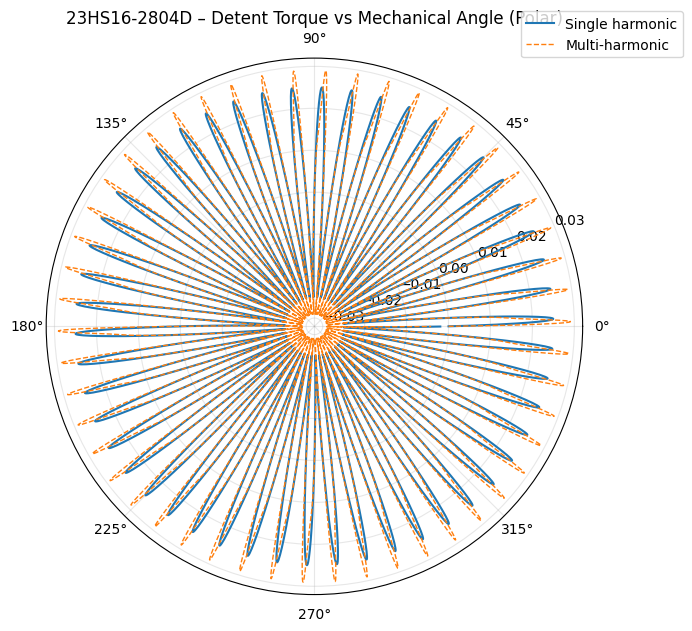

In [5]:
# =====================================
# Motor / model parameters
# (23HS16-2804D, NEMA 23, hybrid)
# =====================================

step_angle_deg = 1.8           # from datasheet
steps_per_rev  = int(360 / step_angle_deg)  # 200 steps/rev

# For a standard 1.8° 2-phase hybrid stepper:
# rotor teeth ≈ 50, giving 200 steps/rev (4 microstates per tooth).
rotor_teeth = 50

# Assume the fundamental detent torque has one cycle per rotor tooth:
N_cog_cycles = rotor_teeth     # 50 cycles per mechanical revolution

# In the earlier formula tau = T_dm * sin(2 p θ + φ),
# the factor (2 p) is the number of torque periods per rev.
# So set 2 p = N_cog_cycles → p = N_cog_cycles / 2
p = N_cog_cycles / 2.0         # p = 25.0 → 2p = 50

# Detent torque amplitude:
# Datasheet only gives holding torque 0.55 N·m.
# Typical detent torque is a few % of holding torque.
T_holding = 0.55               # N·m
T_dm = 0.025                   # N·m, ~4.5% of holding torque (GUESS)
phi = 0.0                      # rad, phase offset

# Multi-harmonic model: (k, T_k, phi_k). GUESSING AT AMPLITUDES.
# To form a proper model, these values would need to be extracted from experimental data via fourier transform of the
# measured torque ripple.
harmonics = [
    (1, 0.025, 0.0),           # fundamental
    (2, 0.008, 0.0),           # 2nd harmonic
    (3, 0.004, 0.0),           # 3rd harmonic
]

# Samples over 1 mechanical revolution
N_samples = 4000
theta = np.linspace(0.0, 2.0 * np.pi, N_samples, endpoint=False)  # mechanical [rad]

# =====================================
# Generate data
# =====================================

tau_single = tau_det_single(theta, T_dm=T_dm, p=p, phi=phi)
tau_multi  = tau_det_multi(theta, harmonics=harmonics, p=p)

# =====================================
# Polar plot
# =====================================

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='polar')

# NOTE: Passing signed torque as radius means negative torque
# is plotted as r>0 at angle + π, which gives a starburst pattern.
ax.plot(theta, tau_single, label="Single harmonic", linewidth=1.5)
ax.plot(theta, tau_multi,  label="Multi-harmonic", linestyle="--", linewidth=1.0)

ax.set_title("23HS16-2804D – Detent Torque vs Mechanical Angle (Polar)")
# use set_rgrids for radial tick locations on polar axes (more widely recognized)
# ax.set_rgrids([0.01, 0.02, 0.03])   # tweak to taste
# ax.set_rlabel_position(90)          # move radial labels out of the way
ax.grid(True, alpha=0.3)
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

plt.tight_layout()
plt.show()
